# MSBD 5001 in-class project

**Description**
The dataset provides the average traffic speed per hour for a major road in Hong Kong from 2017 to 2018. Part of the dataset is provided as the training data, and your task is to predict the rest. 80% of the dataset is provided as the training data and 20% as the testing data, including the timestamp and the corresponding average speed. We sampled the testing data only from the year 2018 to provide you a training dataset that has the complete data spanning the year 2017. However, the speed information is sometimes missing due to device malfunction.

You have to submit the predicted results of these testing samples, which are then compared with the ground truth to evaluate the performance of your model.

In [172]:
"""     
Student Name:  ZHANG Xinyue
Student ID:    20750194
Assignment #:  kaggle in-class project
Student Email: xzhangfa@connect.ust.hk
Course Name:   MSBD5001
URL in github: 
"""

'     \nStudent Name:  ZHANG Xinyue\nStudent ID:    20750194\nAssignment #:  kaggle in-class project\nStudent Email: xzhangfa@connect.ust.hk\nCourse Name:   MSBD5001\nURL in github: \n'

In [173]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics
from xgboost import plot_importance
from sklearn.model_selection import train_test_split,GridSearchCV
%matplotlib inline                                
#no need to do plt.show()

> ### 1.Loading data & show hist 

In [174]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [175]:
train.describe()                   #speed 32.779118 mean

,id,speed
count,14006.00000,14006.000000
mean,7002.50000,32.779118
std,4043.32827,13.573813
min,0.00000,2.573417
25%,3501.25000,19.301089
50%,7002.50000,36.580595
75%,10503.75000,45.877665
max,14005.00000,53.161286


In [176]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


In [177]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3504 non-null   int64 
 1   date    3504 non-null   object
dtypes: int64(1), object(1)
memory usage: 54.9+ KB


In [178]:
train.isnull().sum()   # no null

id       0
date     0
speed    0
dtype: int64

Text(0, 0.5, 'Frequency')

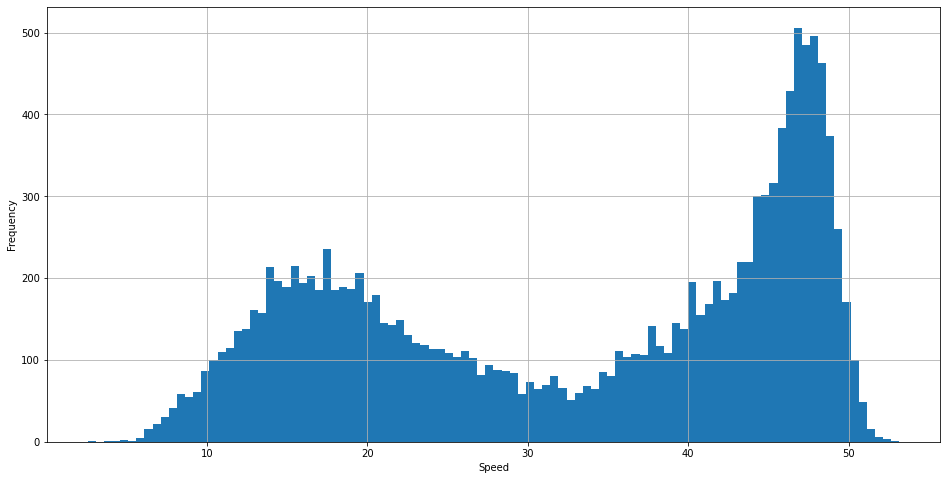

In [179]:
train.speed.hist(bins=100,figsize = (16,8))
plt.xlabel("Speed")
plt.ylabel("Frequency")

> ### 2.Trainning data preprocessing
**Problems:** 
* open train.csv, time is a type of string
* only one train.csv, no label
* Extract temporal features

| id       | date   |  speed  |
| --------   | -----:  | :----:  |
| 0      | 1/1/2017 0:00   |   43.002930     |
| 1        |  1/1/2017 1:00    |   46.1186969   |

In [180]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)


 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')


> ### 3.Feature engineering
**Methods** 
* encoder   2017-0  2018-1
* time transformation -> year+month+day+hr+weekday
* Hong Kong public holiday
* 1.https://www.gov.hk/tc/about/abouthk/holiday/2018.htm
  2.https://www.gov.hk/tc/about/abouthk/holiday/2017.htm
* weather information crawled from internet

In [181]:
weather = pd.read_csv('./weather.csv', parse_dates=['Time'])
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day

print(weather.head())

FileNotFoundError: [Errno 2] No such file or directory: './weather.csv'

In [182]:
weather1=weather[['year','month','day','Wind']]
print(weather1.head())

   year  month  day  Wind
0  2018      1    1     8
1  2018      1    2     8
2  2018      1    3     8
3  2018      1    4     8
4  2018      1    5     0


In [183]:
#########year+month+day+he+weekday
for df in (train,test):
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekday"] = df['date'].dt.weekday
#########year encoder
for df in (train,test):
    df['year1'] = np.nan 
    
    df.loc[(df.year==2017),'year1']= 0 
    df.loc[(df.year==2018),'year1']= 1 
#########早晚高峰
for df in (train,test):
    df['hr_categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 9)&(df.hr >= 7), 'hr_categori'] = "rush"   #工作日的早高峰7-9点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 18)&(df.hr >= 16), 'hr_categori'] = "rush"  #工作日的晚高峰16-18点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 16)&(df.hr > 9), 'hr_categori'] = "day"
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 7)|(df.hr > 18), 'hr_categori'] = "night"
    df.loc[(df.weekday >= 5)&(df.hr < 18)&(df.hr > 7), 'hr_categori'] = "day"                        #周末的白天
    df.loc[(df.weekday >= 5)&(df.hr <= 7)|(df.hr >= 18), 'hr_categori'] = "night"                    #周末的晚上
#########add 2017 2018 holiday
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

#########season
season_dict = {
    3: 0, 4: 0, 5: 0,
    6: 1, 7: 1, 8: 1,
    9: 2, 10: 2, 11: 2,
    12: 3, 1: 3, 2: 3,}                     #0 spring     1  summer      2  fall       3  winter

for df in (train,test):
    df['season']=df['month'].map(season_dict)
    
#########weather
train = pd.merge(train, weather1, on = ['year','month', 'day'], how = 'left')
test = pd.merge(test, weather1, on = ['year','month', 'day'], how = 'left')

df_train = train.drop(columns= ['only-ymd','date','id'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()
wind_train = pd.get_dummies(df_train['Wind'], prefix='w', prefix_sep='_')
wind_test = pd.get_dummies(df_test['Wind'], prefix='w', prefix_sep='_') 

df_train.drop(['Wind'],axis = 1)
df_test.drop(['Wind'],axis = 1)

df_train = pd.concat([df_train,wind_train], axis=1)

df_test = pd.concat([df_test,wind_test], axis=1)

df_train=df_train.drop(['year'],axis=1)
df_test=df_test.drop(['year'],axis=1)

df_train


,speed,month,day,hr,weekday,year1,hr_categori,y/n-holiday,season,Wind,...,w_2,w_3,w_5,w_6,w_7,w_8,w_10,w_12,w_14,w_16
0,43.002930,1,1,0,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
1,46.118696,1,1,1,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
2,44.294158,1,1,2,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
3,41.067468,1,1,3,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
4,46.448653,1,1,4,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,19.865269,12,31,12,0,1.0,day,0,3,5,...,0,0,1,0,0,0,0,0,0,0
14002,17.820375,12,31,15,0,1.0,day,0,3,5,...,0,0,1,0,0,0,0,0,0,0
14003,12.501851,12,31,16,0,1.0,rush,0,3,5,...,0,0,1,0,0,0,0,0,0,0
14004,15.979319,12,31,18,0,1.0,night,0,3,5,...,0,0,1,0,0,0,0,0,0,0


In [184]:
df_train.corr()['speed']       #weekday        0.115887 

speed          1.000000
month         -0.028827
day           -0.019485
hr            -0.390044
weekday        0.115887
year1          0.015102
y/n-holiday    0.055386
season         0.014134
Wind           0.030279
w_0           -0.020286
w_2            0.007465
w_3           -0.005268
w_5           -0.002846
w_6           -0.008172
w_7            0.007959
w_8            0.020017
w_10           0.014795
w_12           0.024941
w_14           0.027469
w_16           0.016915
Name: speed, dtype: float64

> ### 4.Feature engineering adjusted
**Methods** 
* less builtin-function - i found the result will be diff
* time transformation -> year+month+day+hr+weekdayindex
* Hong Kong public holiday
* 1.https://www.gov.hk/tc/about/abouthk/holiday/2018.htm
  2.https://www.gov.hk/tc/about/abouthk/holiday/2017.htm
* Wind corr score too slow and one-hot encoder causes more zero in one row  -> delete
* GridSearchCV
* xgb.train
* write to csv

In [185]:
df = pd.read_csv("train.csv")
df["time"] = df["date"].apply(lambda x : int(x[-5:-3]))
df["day"] = df["date"].apply(lambda x : int(x.split('/')[0]))
df["month"] = df["date"].apply(lambda x : int(x.split('/')[1]))
df["year"] = df["date"].apply(lambda x : int(x.split('/')[2][0:4]))
df.drop(["date"], axis = 1, inplace=True)
df.drop(["id"], axis = 1, inplace=True)
ydata = df["speed"]
xdata = df[["time", "day", "month"]]
xdata['year'] = 0
xdata['year'].iloc[8750:14006] = 1
day = df["day"]
weekend = [7]
dayindex = 1
for i in range(1, len(day)):
    if int(day[i-1]) == int(day[i]):
        weekend.append(weekend[-1])
    else:
        dayindex += 1
        if dayindex%7 == 2:
            weekend.append(1)
        elif dayindex%7 == 3:
            weekend.append(2)
        elif dayindex%7 == 4:
            weekend.append(3)
        elif dayindex%7 == 5:
            weekend.append(4)
        elif dayindex%7 == 6:
            weekend.append(5)
        elif dayindex%7 == 0:
            weekend.append(6)
        else: weekend.append(7)
xdata["weekend"] = weekend
dft = pd.read_csv("test.csv")
dft["time"] = dft["date"].apply(lambda x : int(x[-5:-3]))
dft["day"] = dft["date"].apply(lambda x : int(x.split('/')[0]))
dft["month"] = dft["date"].apply(lambda x : int(x.split('/')[1]))
dft["year"] = dft["date"].apply(lambda x : int(x.split('/')[2][0:4]))
dayt = dft["day"]
dft.drop(["date"], axis = 1, inplace=True)
dft.drop(["id"], axis = 1, inplace=True)
xtest = dft[["time", "day", "month"]]  #, 'spring', 'summer', 'autumn', 'winter'
xtest['year'] = 1
weekendt = [1]
daytindex = 1
for i in range(1, len(dayt)):
    if int(dayt[i-1]) == int(dayt[i]):
        weekendt.append(weekendt[-1])
    else:
        daytindex += 1
        if daytindex%7 == 1:
            weekendt.append(1)
        elif daytindex%7 == 2:
            weekendt.append(2)
        elif daytindex%7 == 3:
            weekendt.append(3)
        elif daytindex%7 == 4:
            weekendt.append(4)
        elif daytindex%7 == 5:
            weekendt.append(5)
        elif daytindex%7 == 6:
            weekendt.append(6)
        else: weekendt.append(7)
xtest["weekend"] = weekendt
x1_train=xdata
x1_test=xtest

<ipython-input-185-5c1d8a326f74>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata['year'] = 0
<ipython-input-185-5c1d8a326f74>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata['year'].iloc[8750:14006] = 1


In [186]:
x1_train

,time,day,month,year,weekend
0,0,1,1,0,7
1,1,1,1,0,7
2,2,1,1,0,7
3,3,1,1,0,7
4,4,1,1,0,7
...,...,...,...,...,...
14001,12,31,12,1,1
14002,15,31,12,1,1
14003,16,31,12,1,1
14004,18,31,12,1,1


In [187]:
x1_test

,time,day,month,year,weekend
0,2,1,1,1,1
1,5,1,1,1,1
2,7,1,1,1,1
3,8,1,1,1,1
4,10,1,1,1,1
...,...,...,...,...,...
3499,17,31,12,1,1
3500,19,31,12,1,1
3501,21,31,12,1,1
3502,22,31,12,1,1


In [157]:
traindate = pd.read_csv('./train.csv',parse_dates=['date'])
testdate = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
trdate=traindate['date']
tedate=testdate['date']
xd=pd.concat([x1_train,trdate], axis=1)
xt=pd.concat([x1_test,tedate], axis=1)
xt

,time,day,month,year,weekend,y/n-holiday,y/n-weekday,date
0,2,1,1,1,1,1,0.0,2018-01-01 02:00:00
1,5,1,1,1,1,1,0.0,2018-01-01 05:00:00
2,7,1,1,1,1,1,0.0,2018-01-01 07:00:00
3,8,1,1,1,1,1,0.0,2018-01-01 08:00:00
4,10,1,1,1,1,1,0.0,2018-01-01 10:00:00
...,...,...,...,...,...,...,...,...
3499,17,31,12,1,1,0,0.0,2018-12-31 17:00:00
3500,19,31,12,1,1,0,0.0,2018-12-31 19:00:00
3501,21,31,12,1,1,0,0.0,2018-12-31 21:00:00
3502,22,31,12,1,1,0,0.0,2018-12-31 22:00:00


In [158]:
xd

,time,day,month,year,weekend,y/n-holiday,y/n-weekday,date
0,0,1,1,0,7,0,1.0,2017-01-01 00:00:00
1,1,1,1,0,7,0,1.0,2017-01-01 01:00:00
2,2,1,1,0,7,0,1.0,2017-01-01 02:00:00
3,3,1,1,0,7,0,1.0,2017-01-01 03:00:00
4,4,1,1,0,7,0,1.0,2017-01-01 04:00:00
...,...,...,...,...,...,...,...,...
14001,12,31,12,1,1,0,0.0,2018-12-31 12:00:00
14002,15,31,12,1,1,0,0.0,2018-12-31 15:00:00
14003,16,31,12,1,1,0,0.0,2018-12-31 16:00:00
14004,18,31,12,1,1,0,0.0,2018-12-31 18:00:00


In [159]:
####  add public holiday
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (xd,xt):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

In [160]:
x1_train=xd.drop(['date','only-ymd'],axis=1)
x1_test=xt.drop(['date','only-ymd'],axis=1)

In [161]:
for df in (x1_train,x1_test):
    df['y/n-weekday'] = np.nan 
    df.loc[(df.weekend>=6),'y/n-weekday']=int(1)  #周末为1
    df.loc[(df.weekend<=5),'y/n-weekday']=int(0)  #工作日为0

In [162]:
x1_train

,time,day,month,year,weekend,y/n-holiday,y/n-weekday
0,0,1,1,0,7,0,1.0
1,1,1,1,0,7,0,1.0
2,2,1,1,0,7,0,1.0
3,3,1,1,0,7,0,1.0
4,4,1,1,0,7,0,1.0
...,...,...,...,...,...,...,...
14001,12,31,12,1,1,0,0.0
14002,15,31,12,1,1,0,0.0
14003,16,31,12,1,1,0,0.0
14004,18,31,12,1,1,0,0.0


In [169]:
x_train, x_test, y_train, y_test = train_test_split(x1_train, ydata, test_size=0.01, random_state=1)
pa = {'booster': 'gbtree','objective': 'reg:squarederror','gamma': 0,'max_depth': 60,'lambda': 3,'subsample': 0.5,'colsample_bytree': 1,'min_child_weight': 0,'silent': 0,'eta': 0.01,'seed':1000,'nthread': 4,'reg_alpha': 0,}
dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_test, y_test)
p = list(pa.items())
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(p, dtrain,840,watchlist)
predict_y_train = model.predict(xgb.DMatrix(x_train))
predict_y_test = model.predict(xgb.DMatrix(x_test))

print("train:",metrics.mean_squared_error(y_train, predict_y_train))
print("test:",metrics.mean_squared_error(y_test, predict_y_test))

[15:14:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:34.68359	valid-rmse:33.69289
[1]	train-rmse:34.34432	valid-rmse:33.36371
[2]	train-rmse:34.00872	valid-rmse:33.03836
[3]	train-rmse:33.67659	valid-rmse:32.71642
[4]	train-rmse:33.34737	valid-rmse:32.39741
[5]	train-rmse:33.02169	valid-rmse:32.08211
[6]	train-rmse:32.69894	valid-rmse:31.76913
[7]	train-rmse:32.37934	valid-rmse:31.45932
[8]	train-rmse:32.06284	valid-rmse:31.15320
[9]	train-rmse:31.74950	valid-rmse:30.84957
[10]	train-rmse:31.43958	valid-rmse:30.54883
[11]	train-rmse:31.13262	valid-rmse:30.25060
[12]	train-rmse:30.82913	valid-rmse:29.95707
[13]	train-rmse:30.52845	valid-rmse:29.66532
[14]	train-rmse:30.23175

[175]	train-rmse:7.14506	valid-rmse:6.86995
[176]	train-rmse:7.09195	valid-rmse:6.81870
[177]	train-rmse:7.03921	valid-rmse:6.76793
[178]	train-rmse:6.98716	valid-rmse:6.71627
[179]	train-rmse:6.93557	valid-rmse:6.66760
[180]	train-rmse:6.88438	valid-rmse:6.61777
[181]	train-rmse:6.83318	valid-rmse:6.56934
[182]	train-rmse:6.78352	valid-rmse:6.52166
[183]	train-rmse:6.73454	valid-rmse:6.47220
[184]	train-rmse:6.68572	valid-rmse:6.42600
[185]	train-rmse:6.63748	valid-rmse:6.38065
[186]	train-rmse:6.58973	valid-rmse:6.33363
[187]	train-rmse:6.54303	valid-rmse:6.28801
[188]	train-rmse:6.49654	valid-rmse:6.24368
[189]	train-rmse:6.45033	valid-rmse:6.19936
[190]	train-rmse:6.40470	valid-rmse:6.15569
[191]	train-rmse:6.35953	valid-rmse:6.11659
[192]	train-rmse:6.31558	valid-rmse:6.07408
[193]	train-rmse:6.27124	valid-rmse:6.03013
[194]	train-rmse:6.22712	valid-rmse:5.98797
[195]	train-rmse:6.18425	valid-rmse:5.94559
[196]	train-rmse:6.14181	valid-rmse:5.90449
[197]	train-rmse:6.09938	valid-r

[362]	train-rmse:2.82673	valid-rmse:3.16533
[363]	train-rmse:2.81856	valid-rmse:3.16113
[364]	train-rmse:2.81063	valid-rmse:3.15756
[365]	train-rmse:2.80245	valid-rmse:3.15336
[366]	train-rmse:2.79461	valid-rmse:3.14958
[367]	train-rmse:2.78690	valid-rmse:3.14627
[368]	train-rmse:2.77884	valid-rmse:3.14127
[369]	train-rmse:2.77090	valid-rmse:3.13496
[370]	train-rmse:2.76329	valid-rmse:3.13158
[371]	train-rmse:2.75566	valid-rmse:3.13009
[372]	train-rmse:2.74823	valid-rmse:3.12644
[373]	train-rmse:2.74079	valid-rmse:3.12163
[374]	train-rmse:2.73310	valid-rmse:3.11676
[375]	train-rmse:2.72595	valid-rmse:3.11254
[376]	train-rmse:2.71829	valid-rmse:3.11033
[377]	train-rmse:2.71087	valid-rmse:3.10784
[378]	train-rmse:2.70336	valid-rmse:3.10374
[379]	train-rmse:2.69607	valid-rmse:3.09989
[380]	train-rmse:2.68891	valid-rmse:3.09831
[381]	train-rmse:2.68163	valid-rmse:3.09608
[382]	train-rmse:2.67441	valid-rmse:3.09013
[383]	train-rmse:2.66746	valid-rmse:3.08934
[384]	train-rmse:2.66034	valid-r

[549]	train-rmse:1.88163	valid-rmse:2.85678
[550]	train-rmse:1.87807	valid-rmse:2.85470
[551]	train-rmse:1.87498	valid-rmse:2.85445
[552]	train-rmse:1.87188	valid-rmse:2.85462
[553]	train-rmse:1.86875	valid-rmse:2.85364
[554]	train-rmse:1.86540	valid-rmse:2.85383
[555]	train-rmse:1.86227	valid-rmse:2.85547
[556]	train-rmse:1.85926	valid-rmse:2.85561
[557]	train-rmse:1.85614	valid-rmse:2.85536
[558]	train-rmse:1.85309	valid-rmse:2.85503
[559]	train-rmse:1.84993	valid-rmse:2.85500
[560]	train-rmse:1.84682	valid-rmse:2.85431
[561]	train-rmse:1.84380	valid-rmse:2.85373
[562]	train-rmse:1.84063	valid-rmse:2.85390
[563]	train-rmse:1.83758	valid-rmse:2.85385
[564]	train-rmse:1.83454	valid-rmse:2.85354
[565]	train-rmse:1.83150	valid-rmse:2.85330
[566]	train-rmse:1.82843	valid-rmse:2.85323
[567]	train-rmse:1.82539	valid-rmse:2.85261
[568]	train-rmse:1.82231	valid-rmse:2.85232
[569]	train-rmse:1.81928	valid-rmse:2.85155
[570]	train-rmse:1.81623	valid-rmse:2.85108
[571]	train-rmse:1.81313	valid-r

[736]	train-rmse:1.41773	valid-rmse:2.81820
[737]	train-rmse:1.41582	valid-rmse:2.81858
[738]	train-rmse:1.41380	valid-rmse:2.81872
[739]	train-rmse:1.41185	valid-rmse:2.81841
[740]	train-rmse:1.40998	valid-rmse:2.81847
[741]	train-rmse:1.40813	valid-rmse:2.81858
[742]	train-rmse:1.40607	valid-rmse:2.81817
[743]	train-rmse:1.40411	valid-rmse:2.81911
[744]	train-rmse:1.40229	valid-rmse:2.81883
[745]	train-rmse:1.40040	valid-rmse:2.81888
[746]	train-rmse:1.39840	valid-rmse:2.81907
[747]	train-rmse:1.39647	valid-rmse:2.81854
[748]	train-rmse:1.39458	valid-rmse:2.81752
[749]	train-rmse:1.39266	valid-rmse:2.81674
[750]	train-rmse:1.39087	valid-rmse:2.81641
[751]	train-rmse:1.38895	valid-rmse:2.81611
[752]	train-rmse:1.38718	valid-rmse:2.81665
[753]	train-rmse:1.38531	valid-rmse:2.81714
[754]	train-rmse:1.38342	valid-rmse:2.81658
[755]	train-rmse:1.38157	valid-rmse:2.81751
[756]	train-rmse:1.37967	valid-rmse:2.81749
[757]	train-rmse:1.37785	valid-rmse:2.81706
[758]	train-rmse:1.37586	valid-r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

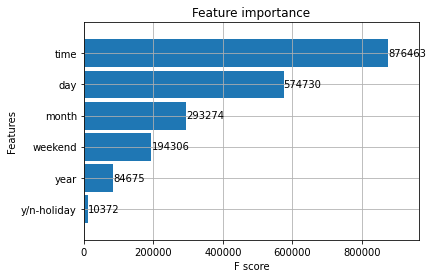

In [170]:
fscores = model.get_fscore()
#top_50_list = sorted(fscores, key=fscores.get, reverse=True)[:50]
#比如获得前50个特征的排序

xgb.plot_importance(model, max_num_features=20, height=0.9)
#前20特征值绘制条状图

In [171]:
pred = model.predict(xgb.DMatrix(x1_test))
pred

array([48.30524 , 47.70376 , 36.40325 , ..., 46.22405 , 40.487232,
       42.720665], dtype=float32)

In [167]:
result = pd.DataFrame({"id":range(3504), "speed":pred})
result.to_csv("submission.csv", index=False)